In [1]:
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,precision_recall_fscore_support,classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
import pickle
%matplotlib inline
stopwords = stopwords.words('english')

## Load Trained Models

In [2]:
MODEL = "un_svc_model.sav"
loaded_model = pickle.load(open("../models/"+MODEL, 'rb'))

In [3]:
loaded_model.best_params_

{'clf__C': 1.0,
 'clf__kernel': 'sigmoid',
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

## 1. preprocessing

In [4]:
# getting the extracted news as df
data1 = pd.read_csv('../data/extracted_data.csv').drop('Unnamed: 0', axis=1)
data1.columns = ['url','section','location','headline','text','label']


# getting the extracted test news as df
data2 = pd.read_csv('../data/extracted_test_data.csv').drop('Unnamed: 0', axis=1)
data2.columns = ['url','section','location','headline','text','label']

# merging headline and content as another column and create another dataframe with jusst text and label.
df1 = pd.DataFrame([data1.headline+". "+data1.text,data1.label]).transpose()
df1.columns = ['text','label']


# merging headline and content as another column and create another dataframe with jusst text and label.
df2 = pd.DataFrame([data2.headline+". "+data2.text,data2.label]).transpose()
df2.columns = ['text','label']

df = pd.concat([df1,df2])

df = df.reset_index().drop('index',axis=1)

# here is the text
df.text

In [8]:
# preprocessing function 
    # split an article into sentences
        # go to each sentence and split it to words
            # if this word  is not in stopwords or other common words I've decided
                #AND
                   # if its alphabetic (getting rid of puctuation and numbers)
                        #AND
                            # if len of the word is greater than 2
                            
                            # lemmatize and lowercase the the word
                            
                            # return the cleaned article
def preprocess(news):
    l = WordNetLemmatizer()
    sentences = news.split(".")
    return " ".join([l.lemmatize(word.lower()) for sentence in sentences for word in sentence.split() if word not in stopwords if word.isalpha() if len(word)> 2 if word.lower() not in ["said","the","first","also","would","one","two","they"]])

In [9]:
original_df = df.copy()

In [10]:
# apply preprocess() function to each article
df['text'] = df['text'].map(preprocess)

In [11]:
df.text

0      reader mail ruling alimony supreme court exten...
1      niqaab elephant say judge person may give evid...
2      grandparent honoured staff student global publ...
3      fisherman call strike country boat fisherman l...
4      badal meet seek clemency bhullar punjab chief ...
                             ...                        
769    civil supply dept invite proposal new logo pro...
770    navarathri celebration reed festival dussehra ...
771    kiran visit area chief minister kiran kumar re...
772    hyderabad baby huggies superstar baby shrihaan...
773    cultural fiesta concludes annual cultural fies...
Name: text, Length: 774, dtype: object

In [12]:
x_train,x_test,y_train,y_test = train_test_split(df.text,list(df.label),test_size=0.3,shuffle=True,random_state=22)

##### **Our data is ready to be fed into vectorizers.**

## 2. exploratory data analysis

### 2.1 word freqs and lenghts

In [13]:
def give_stats(list_of_articles):
    
    number_of_sentences = []
    number_of_words = []
    
    for article in list_of_articles:
        
        sentences = article.split(".")
        no_words = 0
        for sen in sentences:
            
            words = [w for w in sen.split() if len(w) >1]
            
            no_words += len(words)
            
        number_of_sentences.append(len(sentences))
        number_of_words.append(no_words)
        
    return number_of_sentences,number_of_words

In [14]:
s,w = give_stats(original_df.text)

max(s),min(s),max(w),min(w),sum(s)/len(s),sum(w)/len(w)

(170, 3, 1520, 22, 18.63953488372093, 254.2545219638243)

In [15]:
s,w = give_stats(original_df[original_df.label==1].text)

max(s),min(s),max(w),min(w),sum(s)/len(s),sum(w)/len(w)

(60, 3, 1520, 29, 15.133333333333333, 225.5025641025641)

In [16]:
s,w = give_stats(original_df[original_df.label==0].text)

max(s),min(s),max(w),min(w),sum(s)/len(s),sum(w)/len(w)

(170, 3, 1245, 22, 19.820379965457686, 263.9378238341969)

In [17]:
# getting protest and not_protest news
protest_news = df[df.label == 1].text
not_protest_news = df[df.label == 0].text

In [18]:
# freq function:
    # this function will return the first_n frequent words with their ratio in a giving list of articles

def give_freqs(list_of_articles,first_n=10):
    freqs = {}
    for n in list_of_articles:
        words = set(n.split())

        for w in words:
            if w not in freqs:
                freqs[w] = 1
            else:
                freqs[w] += 1

    f = [(freqs[w]/len(list_of_articles),w) for w in freqs]
    f.sort(reverse=True)

    return f[:first_n]

In [19]:
give_freqs(df.text)

[(0.3023255813953488, 'government'),
 (0.28940568475452194, 'state'),
 (0.24160206718346253, 'district'),
 (0.2222222222222222, 'year'),
 (0.2157622739018088, 'minister'),
 (0.20025839793281655, 'take'),
 (0.19767441860465115, 'people'),
 (0.19121447028423771, 'police'),
 (0.19121447028423771, 'day'),
 (0.18992248062015504, 'time')]

In [20]:
give_freqs(protest_news,10)

[(0.4307692307692308, 'state'),
 (0.4307692307692308, 'government'),
 (0.4205128205128205, 'district'),
 (0.4153846153846154, 'protest'),
 (0.4, 'police'),
 (0.29743589743589743, 'leader'),
 (0.27692307692307694, 'minister'),
 (0.26153846153846155, 'member'),
 (0.2512820512820513, 'party'),
 (0.24615384615384617, 'staged')]

In [21]:
give_freqs(not_protest_news,10)

[(0.25906735751295334, 'government'),
 (0.24179620034542315, 'state'),
 (0.24006908462867013, 'year'),
 (0.21243523316062177, 'time'),
 (0.21243523316062177, 'take'),
 (0.20552677029360966, 'new'),
 (0.19516407599309155, 'people'),
 (0.19516407599309155, 'minister'),
 (0.18652849740932642, 'day'),
 (0.18134715025906736, 'district')]

##### These two list has some common words with different ratios lets get what are the differences in the top 10 words

In [22]:
protest_words = set([i[1] for i in give_freqs(protest_news,10)])-set([i[1] for i in give_freqs(not_protest_news,10)])

# these are protest words which are not in not_protest words
protest_words

{'leader', 'member', 'party', 'police', 'protest', 'staged'}

In [23]:
not_protest_words= set([i[1] for i in give_freqs(not_protest_news,10)])-set([i[1] for i in give_freqs(protest_news,10)])
# same for the not_protest news
not_protest_words

{'day', 'new', 'people', 'take', 'time', 'year'}

### 2.2 word affects & distinctive words

##### Now, lets figure of what a single word can tell us about articles

#### "protest" affect:

as it can be seen on the word freqs "protest" is exists in the ~40% of the protest news and it does not exist on the not_protest news.

In [24]:
# bayes theorem. 
    # finding the probability for being protest or not protest for an article which includes given word
def word_affect(word):
    number_of_occurance_in_protest_list = 0
    for article in protest_news:
        for w in article.split():
            if w == word:
                number_of_occurance_in_protest_list +=1
                break 
                
    number_of_occurance_in_not_protest_list = 0
    for article in not_protest_news:
        for w in article.split():
            if w == word:
                number_of_occurance_in_not_protest_list +=1
                break       

    
    pi1 = len(protest_news)/(len(protest_news)+len(not_protest_news))
    pi2 = len(not_protest_news)/(len(protest_news)+len(not_protest_news))
    fkx = number_of_occurance_in_protest_list/len(protest_news)
    fkx_ = number_of_occurance_in_not_protest_list/len(not_protest_news)
    prob = (pi1*fkx)/((pi1*fkx)+(pi2*fkx_))
    
    
    #returns (probability of protest, probability of not protest)
        # this is might seem counterintutitive with word freqs but we must remember the ratio of news
    return(prob,1-prob)

In [25]:
word_affect("protest")

(0.801980198019802, 0.19801980198019797)

In [26]:
word_affect("holiday")

(0.25000000000000006, 0.75)

In [27]:
word_affect("police")

(0.5270270270270271, 0.4729729729729729)

### 2.3 class disturbition

0    579
1    195
Name: label, dtype: int64
0.562015503875969


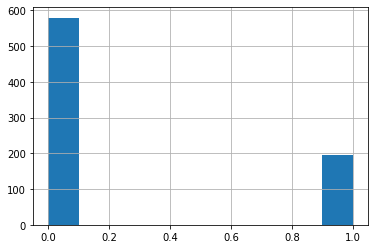

In [28]:
print(df.label.value_counts())
print(435/sum(df.label.value_counts().values))
df.label.hist()

- as it can be seen from the histogram, we have **unbalanced** data with ~33%,67% ratios.
- this may cause some problems such as;
    - focusing on wrong metrics, like accuracy, may mislead us. since, 67% of the data is 'class 0', if our model will label all the dataset as 'class 0', we'll get 67% accuracy.

##### I will first try some algorithms on whole dataset and then try to handle the "unbalanced data" problem withh under-sampling

## 3. Training on Whole Data

## 3.1 prepare data

In [29]:
model_x = df.text
model_y = list(df.label)

train_articles = x_train
train_labels = y_train


test_articles =  x_test
test_labels = y_test

In [30]:
df.label.value_counts()

0    579
1    195
Name: label, dtype: int64

## 3.2 GridSearch for Algorithms

### 3.2.1 Logistic Regression

In [31]:
log_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=200)),
])

hyperparameters = dict(
    tfidf__min_df      = (4, 10, 16),
    tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
    clf__C             = np.logspace(1,4,6)
    #clf__class_weight  = [{1:1,0:1},{1:2,0:1},{1:3,0:0.5}]
)

log_grid_search = GridSearchCV(log_pipeline, hyperparameters,cv=5,scoring='f1_macro')

log_grid_search.fit(train_articles, train_labels)

log_grid_search.best_score_

0.820233420070825

In [32]:
log_grid_search.best_params_

{'clf__C': 39.810717055349734,
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

In [33]:
print(classification_report(train_labels,
                            log_grid_search.predict(train_articles)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       136

    accuracy                           1.00       541
   macro avg       1.00      1.00      1.00       541
weighted avg       1.00      1.00      1.00       541



__Test Scores For LogisticRegression()__

In [34]:
print(classification_report(test_labels,
                            log_grid_search.predict(test_articles)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       174
           1       0.90      0.63      0.74        59

    accuracy                           0.89       233
   macro avg       0.89      0.80      0.83       233
weighted avg       0.89      0.89      0.88       233



In [36]:
confusion_matrix(log_grid_search.predict(test_articles),
                 test_labels)

array([[170,  22],
       [  4,  37]], dtype=int64)

### Save Logistic Model

In [135]:
log_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4, ngram_range = (1,2))),
    ('clf', LogisticRegression(max_iter=200, C = 15)),
])

log_model.fit(model_x,model_y)

confusion_matrix(log_model.predict(model_x),model_y)

array([[579,   0],
       [  0, 195]], dtype=int64)

In [136]:
filename = 'C_logistic_model.sav'
pickle.dump(log_model, open("../models/"+filename, 'wb'))

### 3.2.2 Support Vector Classifier

In [137]:
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC()),
])

hyperparameters = dict(
    tfidf__min_df      = (4, 10, 16),
    tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
    clf__kernel        = ["linear", "poly","sigmoid"],
    clf__gamma         = ('scale', 'auto'),
    clf__C             = np.logspace(1,4,6)

)

svc_grid_search = GridSearchCV(svc_pipeline, hyperparameters,cv=3,scoring='f1_macro')

svc_grid_search.fit(train_articles, train_labels)

svc_grid_search.best_score_

0.8098840096106842

In [138]:
svc_grid_search.best_params_

{'clf__C': 10.0,
 'clf__gamma': 'scale',
 'clf__kernel': 'linear',
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

In [139]:
print(classification_report(train_labels,
                            svc_grid_search.predict(train_articles)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       136

    accuracy                           1.00       541
   macro avg       1.00      1.00      1.00       541
weighted avg       1.00      1.00      1.00       541



___Test Scores For SVC()___ 

In [140]:
print(classification_report(test_labels,
                            svc_grid_search.predict(test_articles)))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       174
           1       0.91      0.69      0.79        59

    accuracy                           0.91       233
   macro avg       0.91      0.84      0.86       233
weighted avg       0.91      0.91      0.90       233



In [86]:
confusion_matrix(test_labels,svc_grid_search.predict(test_articles))

array([[170,   4],
       [ 18,  41]], dtype=int64)

### Save SVC Model

In [87]:
svc_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
    ('clf', SVC(kernel="linear",gamma="scale",C =5,probability=1))])

svc_model.fit(train_articles,train_labels)

confusion_matrix(svc_model.predict(test_articles),test_labels)

array([[170,  18],
       [  4,  41]], dtype=int64)

In [88]:
filename = 'C_svc_model.sav'
pickle.dump(svc_model, open("../models/"+filename, 'wb'))

### 3.2.3 KNN Classifier

In [96]:
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',KNeighborsClassifier()),
])

hyperparameters = dict(
    tfidf__min_df      = (4, 10, 16, 20),
    tfidf__ngram_range = ((1, 1), (1, 2),(1,3)),
    clf__n_neighbors   = (20,25,35),
    clf__weights       = ('uniform','distance'),
    clf__p             = (1,2)
)

knn_grid_search = GridSearchCV(knn_pipeline, hyperparameters,cv=5,scoring='f1_macro')

knn_grid_search.fit(train_articles, train_labels)

knn_grid_search.best_score_

0.798718234624672

In [97]:
knn_grid_search.best_params_

{'clf__n_neighbors': 25,
 'clf__p': 2,
 'clf__weights': 'uniform',
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 1)}

In [98]:
print(classification_report(train_labels,
                            knn_grid_search.predict(train_articles)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       405
           1       0.82      0.65      0.72       136

    accuracy                           0.88       541
   macro avg       0.86      0.80      0.82       541
weighted avg       0.87      0.88      0.87       541



___Test Scores For KNN()___ 

In [99]:
print(classification_report(test_labels,
                            knn_grid_search.predict(test_articles)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       174
           1       0.80      0.66      0.72        59

    accuracy                           0.87       233
   macro avg       0.84      0.80      0.82       233
weighted avg       0.87      0.87      0.87       233



In [100]:
confusion_matrix(test_labels,
                 knn_grid_search.predict(test_articles))

array([[164,  10],
       [ 20,  39]], dtype=int64)

In [101]:
knn_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=4,ngram_range=(1,1))),
    ('clf',KNeighborsClassifier(n_neighbors=25,p=2,weights ='uniform')),
])

knn_model.fit(model_x,model_y)

confusion_matrix(knn_model.predict(test_articles),test_labels)

array([[167,  14],
       [  7,  45]], dtype=int64)

In [102]:
filename = 'C_knn_model.sav'
pickle.dump(knn_model, open("../models/"+filename, 'wb'))

### 3.2.4 Ensembling All Three

In [106]:
s = svc_grid_search.predict(test_articles)
l = log_grid_search.predict(test_articles)
k = knn_grid_search.predict(test_articles)

e = []
for i in s+l+k:
    if i > 1.5:
        e.append(1)
    else:
        e.append(0)

In [108]:
print(classification_report(test_labels,
                            e))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       174
           1       0.90      0.61      0.73        59

    accuracy                           0.88       233
   macro avg       0.89      0.79      0.83       233
weighted avg       0.89      0.88      0.88       233



In [109]:
confusion_matrix(test_labels,
                 e)

array([[170,   4],
       [ 23,  36]], dtype=int64)

On this settings, Logistic Regression is doing slighlty better than SVC

##### Now, let's try same procedure for Under-Sampled Data

## 4. Trainin on Under-Sampled Data

## 4.1 prepare data

In [58]:
undersampled_data =pd.concat([df[df.label == 0].sample(195),df[df.label == 1]]).sample(390).reset_index().drop('index',axis=1)

In [82]:
undersampled_train_x = undersampled_data.text
undersampled_train_y = list(undersampled_data.label)

un_train_articles,un_test_articles,un_train_labels,un_test_labels = train_test_split(undersampled_train_x,undersampled_train_y,
                                                                                    test_size=0.3,shuffle=True)

1    195
0    195
Name: label, dtype: int64


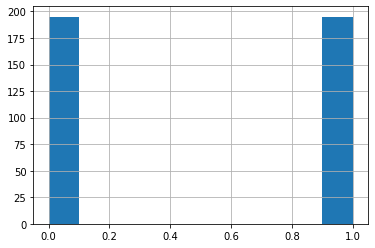

In [83]:
print(undersampled_data.label.value_counts())
undersampled_data.label.hist()

###### we achieved the balance by sacrificing on almost half of our data

## 4.2 GridSearch for Algorithms with Undersampling

### 4.2.1 Logistic Regression

In [84]:
un_log_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=200)),
])

hyperparameters = dict(
    tfidf__min_df      = (4, 10, 16),
    tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
    clf__C             = (1,5,10,15)
    #clf__class_weight  = [{1:1,0:1},{1:2,0:1},{1:3,0:0.5}]
)

un_log_grid_search = GridSearchCV(un_log_pipeline, hyperparameters,cv=5,scoring='f1_macro')

un_log_grid_search.fit(un_train_articles, un_train_labels)

un_log_grid_search.best_score_

0.8712123949313831

In [85]:
un_log_grid_search.best_params_

{'clf__C': 15, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 3)}

__Test Scores For LogisticRegression()__

In [86]:
print(classification_report(un_test_labels,
                            un_log_grid_search.predict(un_test_articles)))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        63
           1       0.84      0.87      0.85        54

    accuracy                           0.86       117
   macro avg       0.86      0.86      0.86       117
weighted avg       0.86      0.86      0.86       117



In [87]:
filename = 'un_logistic_model.sav'
pickle.dump(un_log_grid_search, open("../models/"+filename, 'wb'))

### 4.2.2 Support Vector Classifier

In [89]:
un_svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC()),
])

hyperparameters = dict(
    tfidf__min_df      = (4, 10, 16),
    tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
    clf__kernel        = ["linear", "poly","sigmoid"],
    clf__C             = np.logspace(0,2,5)
    #clf__class_weight  = [{1:1,0:1},{1:2,0:1},{1:3,0:0.5}]
)

un_svc_grid_search = GridSearchCV(un_svc_pipeline, hyperparameters,cv=3,scoring='f1_macro')

un_svc_grid_search.fit(un_train_articles, un_train_labels)

un_svc_grid_search.best_score_

0.8487828585759774

In [90]:
un_svc_grid_search.best_params_

{'clf__C': 1.0,
 'clf__kernel': 'sigmoid',
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

__Test Scores For SVC()__

In [92]:
print(classification_report(un_test_labels,
                            un_svc_grid_search.predict(un_test_articles)))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        63
           1       0.84      0.87      0.85        54

    accuracy                           0.86       117
   macro avg       0.86      0.86      0.86       117
weighted avg       0.86      0.86      0.86       117



In [94]:
confusion_matrix(un_test_labels,
                 un_svc_grid_search.predict(un_test_articles))

array([[54,  9],
       [ 7, 47]], dtype=int64)

In [96]:
filename = 'un_svc_model.sav'
pickle.dump(un_svc_grid_search, open("../models/"+filename, 'wb'))

### 4.2.3 KNN Classifier

In [97]:
un_knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',KNeighborsClassifier()),
])

hyperparameters = dict(
    tfidf__min_df      = (1, 4, 10, 16, 20),
    tfidf__ngram_range = ((1, 1), (1, 2)),
    clf__n_neighbors   = (10,15,20,25),
    clf__weights       = ('uniform','distance'),
    clf__p             = (1,2)
)

un_knn_grid_search = GridSearchCV(un_knn_pipeline, 
                                  hyperparameters,
                                  cv=3,
                                  scoring='f1_macro')

un_knn_grid_search.fit(un_train_articles, un_train_labels)

un_knn_grid_search.best_score_

0.7712518923199124

In [98]:
un_knn_grid_search.best_params_

{'clf__n_neighbors': 20,
 'clf__p': 2,
 'clf__weights': 'uniform',
 'tfidf__min_df': 16,
 'tfidf__ngram_range': (1, 1)}

__Test Scores For SVC()__

In [99]:
print(classification_report(un_test_labels,
                            un_knn_grid_search.predict(un_test_articles)))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74        63
           1       0.68      0.91      0.78        54

    accuracy                           0.76       117
   macro avg       0.78      0.77      0.76       117
weighted avg       0.79      0.76      0.76       117



#### Undersampling is not providing better results and SVC() is giving slightly better results than LogisticRegression() on the original data.